In [1]:
import os
import joblib
import json

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import f1_score, multilabel_confusion_matrix, \
    classification_report, accuracy_score

import numpy as np
import matplotlib.pyplot as plt

import torch

In [ ]:
# TODO: instead of averaging models of all types, we should only average models
# trained with the same set of hyperparameters

# TODO: since training is a random process, we can also train several models
# using the same hyperparameters and partition of the dataset. Then, when
# averaging, we should average over models with the same hyperparameters but
# different dataset partition

# TODO: Maybe we should not average models as a method to improve privacy

# Create datasets

In [2]:
cwd = os.getcwd()

datasets = ['Chowell_train', 'Chowell_test', 'MSK1', 'MSK2', 'Shim_NSCLC',
            'Kato_panCancer', 'Vanguri_NSCLC', 'Ravi_NSCLC', 'Pradat_panCancer']
datasets_ids = list(range(1, len(datasets) + 1))

In [4]:
# Create whole models dataset
model_name = 'llr6' # 'llr6' or 'nn2'
scaler_type = 'standard' # 'standard' or 'minimax'

all_labels = []
all_params = []
all_bal_accs = []
all_auc_scores = []

datasets_dir = os.path.join(cwd, 'datasets', model_name, scaler_type, 'average')
os.makedirs(datasets_dir, exist_ok=True)

models_dir = os.path.join(cwd, 'models', model_name, scaler_type, 'average')
for comb in os.listdir(models_dir):
    aux_labels = [int(n) - 1 for n in comb.split('_')]
    one_hot_label = torch.zeros(len(datasets))
    one_hot_label[aux_labels] = 1
    
    comb_dir = os.path.join(models_dir, comb)
    for C in [0.1, 1.0, 10.0]:
        for l1 in [0.0, 0.5, 1.0]:
            for i in range(100):
                params_file = f'{C}_{l1}_{i}_params.pkl'
                bal_accs_file = f'{C}_{l1}_{i}_bal_accs.json'
                auc_scores_file = f'{C}_{l1}_{i}_auc_scores.json'
                
                # params
                params_dir = os.path.join(comb_dir, params_file)
                params = joblib.load(params_dir)
                    
                all_labels.append(one_hot_label.clone())
                all_params.append(params.clone())
                
                aux_labels = [int(n) - 1 for n in comb.split('_')]
                
                # bal accs
                bal_accs_dir = os.path.join(comb_dir, bal_accs_file)
                with open(bal_accs_dir, 'r') as f:
                    bal_accs_dict = json.load(f)
                
                bal_accs_vector = torch.zeros(len(datasets) + 1)
                for dat_id in datasets_ids:
                    bal_accs_vector[dat_id - 1] = bal_accs_dict[str(dat_id)]
                bal_accs_vector[-1] = bal_accs_dict['all']
                
                all_bal_accs.append(bal_accs_vector)
                
                # auc scores
                auc_scores_dir = os.path.join(comb_dir, auc_scores_file)
                with open(auc_scores_dir, 'r') as f:
                    auc_scores_dict = json.load(f)
                
                auc_scores_vector = torch.zeros(len(datasets) + 1)
                for dat_id in datasets_ids:
                    auc_scores_vector[dat_id - 1] = auc_scores_dict[str(dat_id)]
                auc_scores_vector[-1] = auc_scores_dict['all']
                
                all_auc_scores.append(auc_scores_vector)

all_labels = torch.stack(all_labels, dim=0).int()
all_params = torch.stack(all_params, dim=0)
all_bal_accs = torch.stack(all_bal_accs, dim=0)
all_auc_scores = torch.stack(all_auc_scores, dim=0)

torch.save((all_labels, all_params, all_bal_accs, all_auc_scores),
           os.path.join(datasets_dir, 'params_multilabel.pt'))

In [5]:
cond = (all_labels == torch.tensor([1, 0, 0, 0, 0, 0, 0, 0, 0])).all(dim=1)

In [6]:
all_labels[cond]

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0],
        [1, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32)

In [7]:
all_params[cond][200:300, :][0]

tensor([ 3.5625e-02, -8.6805e-01,  5.1487e-01, -3.0641e-02,  4.4756e-03,
        -2.9795e-01, -2.8235e-01, -7.2376e-02,  2.7089e-03,  4.8952e-01,
         2.0883e-01,  5.7606e-02, -1.2260e-01, -8.6673e-03,  9.3944e-02,
         7.2984e-04, -6.2564e-02, -9.0208e-01,  4.9290e-01,  5.7316e-02,
        -1.0378e-02, -1.9780e+00], dtype=torch.float64)

In [11]:
# Evaluate on Chowell_test
for iC, C in enumerate([0.1, 1.0, 10.0]):
    for il1, l1 in enumerate([0.0, 0.5, 1.0]):
        i = 3* iC + il1
        aux = all_auc_scores[cond][(i*100):((i+1)*100), 1]
        print(f'{C=:<4}, {l1=}, mean: {aux.mean().item():.4f}, std: {aux.std().item():.4f}')

C=0.1 , l1=0.0, mean: 0.7508, std: 0.0003
C=0.1 , l1=0.5, mean: 0.7527, std: 0.0003
C=0.1 , l1=1.0, mean: 0.7551, std: 0.0005
C=1.0 , l1=0.0, mean: 0.7490, std: 0.0004
C=1.0 , l1=0.5, mean: 0.7496, std: 0.0004
C=1.0 , l1=1.0, mean: 0.7504, std: 0.0004
C=10.0, l1=0.0, mean: 0.7478, std: 0.0005
C=10.0, l1=0.5, mean: 0.7480, std: 0.0005
C=10.0, l1=1.0, mean: 0.7481, std: 0.0006


In [12]:
# Evaluate on Chowell_train
for iC, C in enumerate([0.1, 1.0, 10.0]):
    for il1, l1 in enumerate([0.0, 0.5, 1.0]):
        i = 3* iC + il1
        aux = all_auc_scores[cond][(i*100):((i+1)*100), 0]
        print(f'{C=:<4}, {l1=}, mean: {aux.mean().item():.4f}, std: {aux.std().item():.4f}')

C=0.1 , l1=0.0, mean: 0.7442, std: 0.0001
C=0.1 , l1=0.5, mean: 0.7440, std: 0.0001
C=0.1 , l1=1.0, mean: 0.7406, std: 0.0002
C=1.0 , l1=0.0, mean: 0.7437, std: 0.0001
C=1.0 , l1=0.5, mean: 0.7442, std: 0.0001
C=1.0 , l1=1.0, mean: 0.7443, std: 0.0001
C=10.0, l1=0.0, mean: 0.7433, std: 0.0001
C=10.0, l1=0.5, mean: 0.7434, std: 0.0001
C=10.0, l1=1.0, mean: 0.7434, std: 0.0001


# LLR6

## Load and filter datasets

In [20]:
model_name = 'llr6' # 'llr6' or 'nn2'
scaler_type = 'standard' # 'standard' or 'minimax'
dataset_dir = os.path.join(cwd, 'datasets', model_name, scaler_type, 'average',
                           'params_multilabel.pt')

all_labels, all_params, all_bal_accs, all_auc_scores = \
    torch.load(dataset_dir, weights_only=True)

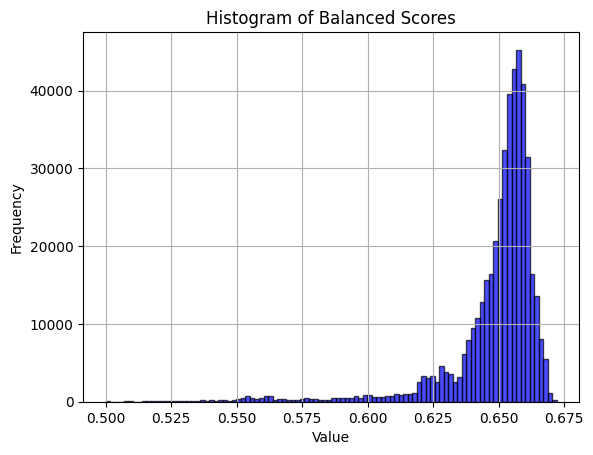

In [21]:
# Plot histogram scores
plt.hist(all_bal_accs[:, -1].numpy(), bins=100, alpha=0.7,
         color='blue', edgecolor='black')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Balanced Scores")
plt.grid(True)

# Show plot
plt.show()

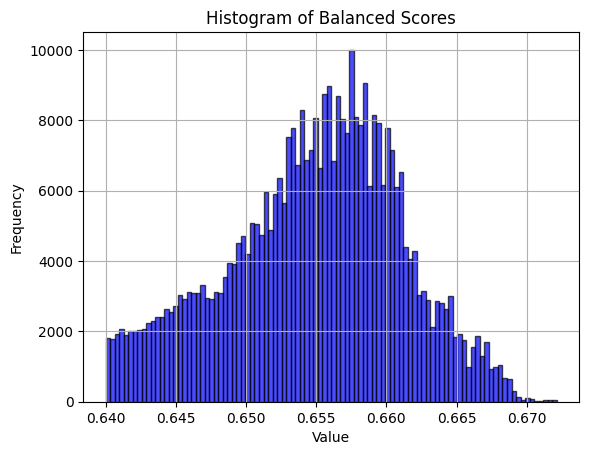

In [22]:
# Plot histogram scores
# idx = (all_bal_accs >= 0.55).all(dim=1)
idx = (all_bal_accs[:, -1] >= 0.64)
filtered_scores = all_bal_accs[idx]
plt.hist(filtered_scores[:, -1].numpy(), bins=100, alpha=0.7,
         color='blue', edgecolor='black')
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title("Histogram of Balanced Scores")
plt.grid(True)

# Show plot
plt.show()

In [23]:
lower_bound = 0.64

# idx = (all_bal_accs >= lower_bound).all(dim=1)
idx = (all_bal_accs[:, -1] >= lower_bound)

all_labels = all_labels[idx]
all_params = all_params[idx]
all_bal_accs = all_bal_accs[idx]
all_auc_scores = all_auc_scores[idx]

## Black-box attack

In [24]:
# Black-box attack
X, y = all_bal_accs, all_labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# Define and train the MLP model
# mlp_bb = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32),
#                        activation="relu",
#                        solver="adam",
#                        max_iter=1000)
mlp_bb = MLPClassifier(hidden_layer_sizes=(128, 32),
                       activation="relu",
                       solver="adam",
                       max_iter=100)
mlp_bb.fit(X_train, y_train)

# Save model
attack_model_dir = os.path.join(cwd, 'attack_models', model_name,
                                scaler_type, 'average')
os.makedirs(attack_model_dir, exist_ok=True)

# joblib.dump(mlp_bb, os.path.join(attack_model_dir,
#                                  'mlp_attacker_multilabel_bb.pkl'))

/export/anaconda3/envs/loris/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


['/mathqi/joserapa/LORIS/attacks/attack_models/llr6/standard/average/mlp_attacker_multilabel_bb.pkl']

In [25]:
attack_model_dir = os.path.join(cwd, 'attack_models', model_name,
                                scaler_type, 'average')
mlp_bb = joblib.load(os.path.join(attack_model_dir,
                                  'mlp_attacker_multilabel_bb.pkl'))

In [26]:
# Predict probabilities and binary labels
y_pred = mlp_bb.predict(X_test)

# Evaluate using F1-score
print("F1-score:", f1_score(y_test, y_pred, average="micro"))
print()

# Compute the confusion matrix for each label separately
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Display confusion matrices per class
for i, cm in enumerate(conf_matrices):
    cm_sum = cm.astype(np.float64).sum(axis=1, keepdims=True)  # Sum per row
    cm_normalized = cm / (cm_sum + 1e-9)  # Avoid division by zero
    print(f"Confusion Matrix for Class {i} - {datasets[i]}:\n{cm_normalized}\n")
print()

# Generate a detailed classification report
print(classification_report(y_test, y_pred, zero_division=0))

F1-score: 0.8479001149888862

Confusion Matrix for Class 0 - Chowell_train:
[[0.94224116 0.05775884]
 [0.00321515 0.99678485]]

Confusion Matrix for Class 1 - Chowell_test:
[[0.91953594 0.08046406]
 [0.0155221  0.9844779 ]]

Confusion Matrix for Class 2 - MSK1:
[[0.97127952 0.02872048]
 [0.09456519 0.90543481]]

Confusion Matrix for Class 3 - MSK2:
[[0.73370286 0.26629714]
 [0.07516059 0.92483941]]

Confusion Matrix for Class 4 - Shim_NSCLC:
[[0.63760897 0.36239103]
 [0.15993179 0.84006821]]

Confusion Matrix for Class 5 - Kato_panCancer:
[[0.51142729 0.48857271]
 [0.22763544 0.77236456]]

Confusion Matrix for Class 6 - Vanguri_NSCLC:
[[0.6886357  0.3113643 ]
 [0.28985945 0.71014055]]

Confusion Matrix for Class 7 - Ravi_NSCLC:
[[0.86640058 0.13359942]
 [0.1130779  0.8869221 ]]

Confusion Matrix for Class 8 - Pradat_panCancer:
[[0.81247922 0.18752078]
 [0.14574103 0.85425897]]


              precision    recall  f1-score   support

           0       0.96      1.00      0.98     46032

## White-box attack

In [9]:
# White-box attack
X, y = all_params, all_labels

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

# Define and train the MLP model
mlp_wb = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32),
                       activation="relu",
                       solver="adam",
                       max_iter=1000)
mlp_wb.fit(X_train, y_train)

# Save model
attack_model_dir = os.path.join(cwd, 'attack_models', model_name)
os.makedirs(attack_model_dir, exist_ok=True)

# joblib.dump(mlp_wb, os.path.join(attack_model_dir,
#                                  'mlp_attacker_multilabel_wb.pkl'))
# joblib.dump(mlp_wb, os.path.join(attack_model_dir,
#                                  'mlp_attacker_multilabel_wb_bigmodel.pkl'))

['/home/jose/VSCodeProjects/LORIS/attacks/attack_models/llr6/mlp_attacker_multilabel_wb.pkl']

In [10]:
attack_model_dir = os.path.join(cwd, 'attack_models', model_name)
mlp_wb = joblib.load(os.path.join(attack_model_dir,
                                  'mlp_attacker_multilabel_wb.pkl'))
# mlp_wb = joblib.load(os.path.join(attack_model_dir,
#                                   'mlp_attacker_multilabel_wb_bigmodel.pkl'))

In [11]:
# Predict probabilities and binary labels
y_pred = mlp_wb.predict(X_test)

# Evaluate using F1-score
print("F1-score:", f1_score(y_test, y_pred, average="micro"))
print()

# Compute the confusion matrix for each label separately
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Display confusion matrices per class
for i, cm in enumerate(conf_matrices):
    cm_sum = cm.astype(np.float64).sum(axis=1, keepdims=True)  # Sum per row
    cm_normalized = cm / (cm_sum + 1e-9)  # Avoid division by zero
    print(f"Confusion Matrix for Class {i} - {datasets[i]}:\n{cm_normalized}\n")
print()

# Generate a detailed classification report
print(classification_report(y_test, y_pred, zero_division=0))

F1-score: 0.8282928770393951

Confusion Matrix for Class 0 - Chowell_train:
[[0.95802469 0.04197531]
 [0.03754266 0.96245734]]

Confusion Matrix for Class 1 - Chowell_test:
[[0.8658147  0.1341853 ]
 [0.07817109 0.92182891]]

Confusion Matrix for Class 2 - MSK1:
[[0.84988453 0.15011547]
 [0.08064516 0.91935484]]

Confusion Matrix for Class 3 - MSK2:
[[0.74545455 0.25454545]
 [0.29637097 0.70362903]]

Confusion Matrix for Class 4 - Shim_NSCLC:
[[0.81598063 0.18401937]
 [0.15051903 0.84948097]]

Confusion Matrix for Class 5 - Kato_panCancer:
[[0.65148515 0.34851485]
 [0.52263374 0.47736626]]

Confusion Matrix for Class 6 - Vanguri_NSCLC:
[[0.528      0.472     ]
 [0.18533605 0.81466395]]

Confusion Matrix for Class 7 - Ravi_NSCLC:
[[0.8807947  0.1192053 ]
 [0.05762082 0.94237918]]

Confusion Matrix for Class 8 - Pradat_panCancer:
[[0.68080357 0.31919643]
 [0.11233886 0.88766114]]


              precision    recall  f1-score   support

           0       0.97      0.96      0.97       586

### Evaluate LORIS

In [62]:
def classify_by_dataset(model, params):
    probs = model.predict_proba(params)[0, :]
    
    for i in range(len(datasets)):
        print(f'{datasets[i]:>16}: {probs[i]:.4f}')

In [63]:
# ['TMB', 'Systemic_therapy_history', 'Albumin', 'NLR', 'Age',
#  'CancerType1', 'CancerType2', 'CancerType3', 'CancerType4',
#  'CancerType5', 'CancerType6', 'CancerType7', 'CancerType8',
#  'CancerType9', 'CancerType10', 'CancerType11', 'CancerType12',
#  'CancerType13', 'CancerType14', 'CancerType15', 'CancerType16']

# S = 0.0371 * min(TMB, 50) - 0.8775 * PSTH + 0.5382 * Albumin - 0.033 * min(NLR, 25) + 0.0049 * min(Age, 85) + CTCT - 2.0886

# CTCT = - 0.3323 * Bladder - 0.3323 * Breast - 0.102 * Colorectal - 0.0079 * Endometrial + 0.55 * Esophageal + 0.2306 * Gastric
#     + 0.0678 * Head&Neck - 0.1189 * Hepatobiliary - 0.0086 * Melanoma + 0.1255 * Mesothelioma + 0.0008 * NSCLC
#     - 0.052 * Ovarian - 1.1169 * Pancreatic + 0.5451 * Renal + 0.0542 * Sarcoma - 0.0033 * SCLC

coeffs = [0.0371, -0.8775, 0.5382, -0.033, 0.0049, -0.3323, -0.3323, -0.102,
          -0.0079, 0.55, 0.2306, 0.0678, -0.1189, -0.0086, 0.1255, 0.0008,
          -0.052, -1.1169, 0.5451, 0.0542, -0.0033, -2.0886]
X_loris = torch.tensor(coeffs).unsqueeze(0)
X_loris

tensor([[ 3.7100e-02, -8.7750e-01,  5.3820e-01, -3.3000e-02,  4.9000e-03,
         -3.3230e-01, -3.3230e-01, -1.0200e-01, -7.9000e-03,  5.5000e-01,
          2.3060e-01,  6.7800e-02, -1.1890e-01, -8.6000e-03,  1.2550e-01,
          8.0000e-04, -5.2000e-02, -1.1169e+00,  5.4510e-01,  5.4200e-02,
         -3.3000e-03, -2.0886e+00]])

In [64]:
classify_by_dataset(mlp_wb, X_loris)

   Chowell_train: 1.0000
    Chowell_test: 0.0012
            MSK1: 0.0000
            MSK2: 0.0016
      Shim_NSCLC: 0.0000
  Kato_panCancer: 0.4788
   Vanguri_NSCLC: 0.0000
      Ravi_NSCLC: 1.0000
Pradat_panCancer: 0.0002


In [ ]:
classify_by_dataset(mlp_wb, X_loris)

   Chowell_train: 0.0000
    Chowell_test: 0.0000
            MSK1: 0.0000
            MSK2: 0.0000
      Shim_NSCLC: 0.0000
  Kato_panCancer: 0.0000
   Vanguri_NSCLC: 0.4936
      Ravi_NSCLC: 0.0000
Pradat_panCancer: 0.0000


In [ ]:
classify_by_dataset(mlp_wb, X_loris)

   Chowell_train: 1.0000
    Chowell_test: 0.0000
            MSK1: 0.0000
            MSK2: 0.9459
      Shim_NSCLC: 0.0000
  Kato_panCancer: 0.0014
   Vanguri_NSCLC: 0.0097
      Ravi_NSCLC: 1.0000
Pradat_panCancer: 0.0345


## White-box attack ensemble

In [ ]:
# White-box attack
X, y = all_params, all_labels

attack_model_dir = os.path.join(cwd, 'attack_models', model_name,
                                scaler_type, 'average')
os.makedirs(attack_model_dir, exist_ok=True)

# First: Train/Test Split (held-out test set)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Save held-out test set (optional)
# joblib.dump((X_test, y_test), os.path.join(attack_model_dir,
#                                            'heldout_test_set.pkl'))

# K-Fold CV on training set
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for fold, (train_index, val_index) in enumerate(kfold.split(X_train_full,
                                                            y_train_full)):
    print(f"Training fold {fold+1}/{n_splits}...")

    X_train, X_val = X_train_full[train_index], X_train_full[val_index]
    y_train, y_val = y_train_full[train_index], y_train_full[val_index]

    # Define and train the model
    # mlp_wb = MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32),
    #                        activation="relu",
    #                        solver="adam",
    #                        max_iter=500)
    mlp_wb = MLPClassifier(hidden_layer_sizes=(128, 32),
                           activation="relu",
                           solver="adam",
                           max_iter=100)
    mlp_wb.fit(X_train, y_train)

    # Save model for this fold
    # joblib.dump(mlp_wb,
    #             os.path.join(attack_model_dir,
    #                          f'mlp_attacker_multilabel_wb_fold_{fold+1}.pkl'))

Training fold 1/5...


In [12]:
# Save held-out test set (optional)
attack_model_dir = os.path.join(cwd, 'attack_models', model_name, scaler_type)
X_test, y_test = joblib.load(os.path.join(attack_model_dir,
                                          'heldout_test_set.pkl'))

# Load models
n_splits = 5
loaded_models = []

# Load each model
for fold in range(1, n_splits + 1):
    model_path = os.path.join(attack_model_dir,
                              f'mlp_attacker_multilabel_wb_fold_{fold}.pkl')
    model = joblib.load(model_path)
    loaded_models.append(model)

In [13]:
# Multilabel: average predictions and apply threshold
all_preds = np.array([model.predict_proba(X_test) for model in loaded_models])
avg_preds = np.mean(all_preds, axis=0)
final_preds = (avg_preds >= 0.5).astype(int)

# Accuracy (or any other metric)
acc = accuracy_score(y_test, final_preds)
print(f"Ensemble accuracy: {acc:.4f}")

Ensemble accuracy: 0.9996


In [14]:
# Evaluate using F1-score
print("F1-score:", f1_score(y_test, final_preds, average="micro"))
print()

# Compute the confusion matrix for each label separately
conf_matrices = multilabel_confusion_matrix(y_test, final_preds)

# Display confusion matrices per class
for i, cm in enumerate(conf_matrices):
    cm_sum = cm.astype(np.float64).sum(axis=1, keepdims=True)  # Sum per row
    cm_normalized = cm / (cm_sum + 1e-9)  # Avoid division by zero
    print(f"Confusion Matrix for Class {i} - {datasets[i]}:\n{cm_normalized}\n")
print()

# Generate a detailed classification report
print(classification_report(y_test, final_preds, zero_division=0))

F1-score: 0.9999532125725206

Confusion Matrix for Class 0 - Chowell_train:
[[1. 0.]
 [0. 1.]]

Confusion Matrix for Class 1 - Chowell_test:
[[1. 0.]
 [0. 1.]]

Confusion Matrix for Class 2 - MSK1:
[[1. 0.]
 [0. 1.]]

Confusion Matrix for Class 3 - MSK2:
[[9.99953630e-01 4.63703601e-05]
 [2.21214467e-05 9.99977879e-01]]

Confusion Matrix for Class 4 - Shim_NSCLC:
[[1.00000000e+00 0.00000000e+00]
 [2.21601737e-05 9.99977840e-01]]

Confusion Matrix for Class 5 - Kato_panCancer:
[[9.99679208e-01 3.20791898e-04]
 [4.47487358e-04 9.99552513e-01]]

Confusion Matrix for Class 6 - Vanguri_NSCLC:
[[1. 0.]
 [0. 1.]]

Confusion Matrix for Class 7 - Ravi_NSCLC:
[[1. 0.]
 [0. 1.]]

Confusion Matrix for Class 8 - Pradat_panCancer:
[[1. 0.]
 [0. 1.]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     46238
           1       1.00      1.00      1.00     46290
           2       1.00      1.00      1.00     45496
           3       1.00      1.00  

### Evaluate LORIS

In [15]:
def classify_by_dataset(models, params):
    # Multilabel: average predictions and apply threshold
    all_preds = np.array([model.predict_proba(params) for model in models])
    avg_preds = np.mean(all_preds, axis=0)
    
    
    for i in range(len(datasets)):
        print(f'{datasets[i]:>16}: {avg_preds[0][i]:.4f}')

In [16]:
# ['TMB', 'Systemic_therapy_history', 'Albumin', 'NLR', 'Age',
#  'CancerType1', 'CancerType2', 'CancerType3', 'CancerType4',
#  'CancerType5', 'CancerType6', 'CancerType7', 'CancerType8',
#  'CancerType9', 'CancerType10', 'CancerType11', 'CancerType12',
#  'CancerType13', 'CancerType14', 'CancerType15', 'CancerType16']

# S = 0.0371 * min(TMB, 50) - 0.8775 * PSTH + 0.5382 * Albumin - 0.033 * min(NLR, 25) + 0.0049 * min(Age, 85) + CTCT - 2.0886

# CTCT = - 0.3323 * Bladder - 0.3323 * Breast - 0.102 * Colorectal - 0.0079 * Endometrial + 0.55 * Esophageal + 0.2306 * Gastric
#     + 0.0678 * Head&Neck - 0.1189 * Hepatobiliary - 0.0086 * Melanoma + 0.1255 * Mesothelioma + 0.0008 * NSCLC
#     - 0.052 * Ovarian - 1.1169 * Pancreatic + 0.5451 * Renal + 0.0542 * Sarcoma - 0.0033 * SCLC

coeffs = [0.0371, -0.8775, 0.5382, -0.033, 0.0049, -0.3323, -0.3323, -0.102,
          -0.0079, 0.55, 0.2306, 0.0678, -0.1189, -0.0086, 0.1255, 0.0008,
          -0.052, -1.1169, 0.5451, 0.0542, -0.0033, -2.0886]
X_loris = torch.tensor(coeffs).unsqueeze(0)
X_loris

tensor([[ 3.7100e-02, -8.7750e-01,  5.3820e-01, -3.3000e-02,  4.9000e-03,
         -3.3230e-01, -3.3230e-01, -1.0200e-01, -7.9000e-03,  5.5000e-01,
          2.3060e-01,  6.7800e-02, -1.1890e-01, -8.6000e-03,  1.2550e-01,
          8.0000e-04, -5.2000e-02, -1.1169e+00,  5.4510e-01,  5.4200e-02,
         -3.3000e-03, -2.0886e+00]])

In [ ]:
# tensor([ 0.0383, -0.9419,  0.4187, -0.0231,  0.0035, -0.1131, -0.1279, -0.1152,
#          0.0253,  0.0543,  0.0398,  0.1074, -0.1001, -0.0067, -0.0130, -0.0044,
#         -0.0276, -0.5440,  0.5321,  0.0412,  0.0756, -1.5578],
#        dtype=torch.float64)

In [ ]:
classify_by_dataset(loaded_models, X_loris)

   Chowell_train: 1.0000
    Chowell_test: 0.0000
            MSK1: 0.9997
            MSK2: 0.9919
      Shim_NSCLC: 0.2042
  Kato_panCancer: 1.0000
   Vanguri_NSCLC: 0.9991
      Ravi_NSCLC: 0.0000
Pradat_panCancer: 0.0000


### Check other models

In [18]:
aux_datasets = [0, 4, 5]
cond1 = y_test.sum(dim=1) == len(aux_datasets)
cond2 = y_test[:, aux_datasets].all(dim=1)
aux_params = X_test[cond1 * cond2]

print(aux_params.shape)
idx = torch.randperm(aux_params.shape[0])[0]
aux_coeffs = aux_params[idx].unsqueeze(0)
aux_coeffs

torch.Size([28, 22])


tensor([[ 0.4457, -0.3815,  0.1710, -0.1545,  0.0886, -0.1159, -0.0283, -0.0149,
          0.0000,  0.0569,  0.0080,  0.0005, -0.0459,  0.0000,  0.0430,  0.0000,
          0.0000, -0.1607,  0.1467,  0.0000,  0.0000, -0.1122]],
       dtype=torch.float64)

In [19]:
classify_by_dataset(loaded_models, aux_coeffs)

   Chowell_train: 1.0000
    Chowell_test: 0.0002
            MSK1: 0.0008
            MSK2: 0.0646
      Shim_NSCLC: 0.9844
  Kato_panCancer: 0.8328
   Vanguri_NSCLC: 0.4854
      Ravi_NSCLC: 0.0006
Pradat_panCancer: 0.0002
